In [1]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
import os
import tensorflow as tf

2025-07-15 06:36:05.072588: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752586565.264752 2064607 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752586565.316141 2064607 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752586565.707610 2064607 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752586565.707640 2064607 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752586565.707643 2064607 computation_placer.cc:177] computation placer alr

In [3]:
# minorized reference
with h5py.File('/global/u2/k/kberard/SCGSR/Research/Diamond/Data/density_tot_ref.h5', 'r') as file:
    #print("Keys: %s" % file.keys())
    ref_d = file['density'][:]
#print(ref_d)
print(ref_d.shape)
minorized_ref_d = (np.sum(ref_d,axis=2))
minorized_ref_d.shape



(64, 64, 64)


(64, 64)

In [4]:
####################################################################################################################################################
def stochastic_density(d,N):
    # poisson model
    #  accurate and fast for all values of N
    # N  = number of MC samples
    assert isinstance(d,np.ndarray)
    assert isinstance(N,(int,float,np.int64,np.float64))
    assert N>0
    ds = np.random.poisson(N*d)/N
    ds*= d.sum()/ds.sum()
    return ds
#end def stochastic_density

####################################################################################################################################################

In [13]:
#################  add more diverse set of training data and fix overfilling!!!!!!!!!!

In [5]:
def generate_single_2d_density(ref_d, noise_level):
    noisy_3d = stochastic_density(ref_d, noise_level)  # shape: (64, 64, 64)
    projected_2d = np.sum(noisy_3d, axis=2)             # shape: (64, 64)
    return projected_2d

# Noise levels to randomly draw from
noise_levels = [10000 * (j + 1) for j in range(5)]  # [10000, 20000, ..., 50000]

# Sizes
num_train = 5000
num_val = 1000
num_test = 500

# Generate train set with mixed noise levels
x_train = np.zeros((num_train, 64, 64))
for i in range(num_train):
    noise_level = np.random.choice(noise_levels)
    x_train[i] = generate_single_2d_density(ref_d, noise_level)

# Generate val set with mixed noise levels
x_val = np.zeros((num_val, 64, 64))
for i in range(num_val):
    noise_level = np.random.choice(noise_levels)
    x_val[i] = generate_single_2d_density(ref_d, noise_level)



print("Train, val, generated")


Train, val, generated


In [6]:
# Generate test set with fixed noise level
x_test = np.zeros((num_test, 64, 64))
for i in range(num_test):
    x_test[i] = generate_single_2d_density(ref_d, 100000)
print("test generated")

test generated


In [7]:
print("here")

here


In [8]:
y_test_3d = np.zeros((x_test.shape[0],64,64,64))
y_train_3d = np.zeros((x_train.shape[0],64,64,64))
y_val_3d = np.zeros((x_val.shape[0],64,64,64))
for i in range (y_test_3d.shape[0]):
    y_test_3d[i]=stochastic_density(ref_d,1000000)
y_test = (np.sum(y_test_3d,axis=2))

for i in range (y_train_3d.shape[0]):
    y_train_3d[i]=stochastic_density(ref_d,1000000)
y_train = (np.sum(y_train_3d,axis=2))

for i in range (y_val_3d.shape[0]):
    y_val_3d[i]=stochastic_density(ref_d,1000000)
y_val = (np.sum(y_val_3d,axis=2))
print("here")

here


In [9]:
print("here")

here


In [10]:
# Add channel dimension
x_train = x_train[..., np.newaxis]
x_val   = x_val[..., np.newaxis]
x_test  = x_test[..., np.newaxis]

y_train = y_train[..., np.newaxis]
y_val   = y_val[..., np.newaxis]
y_test   = y_test[..., np.newaxis]

In [11]:
import tensorflow as tf

def jensen_shannon_divergence_loss(y_true, y_pred):
    y_t = tf.cast(y_true, tf.float32)
    y_p = tf.cast(y_pred, tf.float32)

    y_t = tf.reshape(y_t, [tf.shape(y_t)[0], -1])
    y_p = tf.reshape(y_p, [tf.shape(y_p)[0], -1])

    y_t /= tf.reduce_sum(y_t, axis=1, keepdims=True) + 1e-8
    y_p /= tf.reduce_sum(y_p, axis=1, keepdims=True) + 1e-8

    m = 0.5 * (y_t + y_p)

    kl_true = tf.reduce_sum(y_t * tf.math.log((y_t + 1e-8) / (m + 1e-8)), axis=1)
    kl_pred = tf.reduce_sum(y_p * tf.math.log((y_p + 1e-8) / (m + 1e-8)), axis=1)

    jsd = 0.5 * (kl_true + kl_pred)

    return tf.reduce_mean(jsd)


In [18]:
# must beat the model predicting the average
test_avg = np.mean(x_test[:,:,:,0],axis=0)
print("2 norm difference")
print("Mean vs DFT 2 norm diff")
print(np.linalg.norm(test_avg-minorized_ref_d))


print("divergence difference")              
print("JSD (bar{x_test},y_dft):", jensen_shannon_divergence_loss(test_avg, minorized_ref_d.copy()))

# should be on the order of 1.4 10^-5

2 norm difference
Mean vs DFT 2 norm diff
0.0003981657459381072
divergence difference
JSD (bar{x_test},y_dft): tf.Tensor(1.5349532e-06, shape=(), dtype=float32)


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0480 - val_loss: 0.0470
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0432 - val_loss: 0.0060
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0030 - val_loss: 5.5192e-04
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.2932e-04 - val_loss: 2.1959e-04
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.9185e-04 - val_loss: 1.3471e-04
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.2473e-04 - val_loss: 1.0230e-04
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.7768e-05 - val_loss: 8.7019e-05
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.4682e-05 - val_loss: 7.8875e-05
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.7558e-05 - val_loss: 7.4166e-05
Epoch 10/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.3430e-05 - val_loss: 7.1235e-05
Epoch 11/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.0816

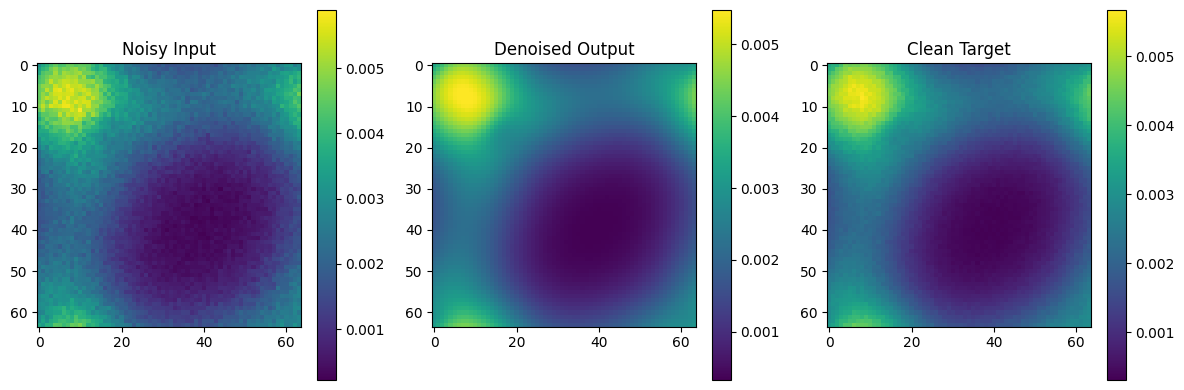

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
from tensorflow.keras.utils import register_keras_serializable


# --- Custom Renormalization Layer ---
@register_keras_serializable(package="Custom")
class Renormalize(tf.keras.layers.Layer):
    def __init__(self, target_sum=8.0, **kwargs):
        super().__init__(**kwargs)
        self.target_sum = target_sum

    def call(self, inputs):
        x_sum = tf.reduce_sum(inputs, axis=[1, 2, 3], keepdims=True)
        return inputs / (x_sum + 1e-8) * self.target_sum

    def get_config(self):
        config = super().get_config()
        config.update({'target_sum': self.target_sum})
        return config


# --- Custom JS Divergence Loss ---
@register_keras_serializable(package="Custom")


def jensen_shannon_divergence_loss(y_true, y_pred):
    y_t = tf.cast(y_true, tf.float32)
    y_p = tf.cast(y_pred, tf.float32)

    y_t = tf.reshape(y_t, [tf.shape(y_t)[0], -1])
    y_p = tf.reshape(y_p, [tf.shape(y_p)[0], -1])

    y_t /= tf.reduce_sum(y_t, axis=1, keepdims=True) + 1e-8
    y_p /= tf.reduce_sum(y_p, axis=1, keepdims=True) + 1e-8

    m = 0.5 * (y_t + y_p)

    kl_true = tf.reduce_sum(y_t * tf.math.log((y_t + 1e-8) / (m + 1e-8)), axis=1)
    kl_pred = tf.reduce_sum(y_p * tf.math.log((y_p + 1e-8) / (m + 1e-8)), axis=1)

    jsd = 0.5 * (kl_true + kl_pred)

    return tf.reduce_mean(jsd)


# --- Create DAE Model ---
def create_dae(input_shape):
    flat_dim = np.prod(input_shape)
    model = tf.keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(flat_dim, activation='sigmoid'),
        layers.Reshape(target_shape=input_shape),
        Renormalize(target_sum=8.0)  # Use the custom layer here
    ])
    return model


# --- Main ---
if __name__ == '__main__':
    input_shape = (64, 64, 1)

    dae = create_dae(input_shape)
    dae.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                loss=jensen_shannon_divergence_loss)

    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    dae.fit(x_train.copy(), y_train.copy(),
            validation_data=(x_val.copy(), y_val.copy()),
            epochs=100,
            batch_size=50,
            callbacks=[early_stop],
            verbose=1)

    # --- Predict and Plot ---
    i = 0
    denoised_norm = dae.predict(x_test.copy()[i:i+1])[0, ..., 0]
    denoised = denoised_norm
    noisy_input = x_test.copy()[i, ..., 0]
    true_clean = y_test.copy()[i, ..., 0]

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(noisy_input, cmap='viridis')
    plt.title("Noisy Input")
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.imshow(denoised, cmap='viridis')
    plt.title("Denoised Output")
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.imshow(true_clean, cmap='viridis')
    plt.title("Clean Target")
    plt.colorbar()

    plt.tight_layout()
    plt.show()


In [14]:
 dae.save("DAE.keras")

In [15]:
# must beat the model predicting the average
test_avg = np.mean(x_test.copy()[:,:,:,0],axis=0)
print("2 norm difference")
print("Mean vs DFT 2 norm diff")
print(np.linalg.norm(test_avg-minorized_ref_d.copy()))
print(test_avg.shape)
print(minorized_ref_d.shape)

print("divergence difference")              
print("JSD (bar{x_test},y_dft):", jensen_shannon_divergence_loss(test_avg, minorized_ref_d.copy()))

# should be on the order of 1.4 10^-5

2 norm difference
Mean vs DFT 2 norm diff
0.0003981657459381072
(64, 64)
(64, 64)
divergence difference
JSD (bar{x_test},y_dft): tf.Tensor(1.5349532e-06, shape=(), dtype=float32)


In [16]:
# must beat the model predicting the average
test_avg = np.mean(x_test[:,:,:,0],axis=0)
print("Mean vs DFT 2 norm diff")
print(np.linalg.norm(test_avg-minorized_ref_d))

print("prediction of one test sample vs DFT")
print(np.linalg.norm(x_test[0,:,:,0]-minorized_ref_d))
print(x_test[0,:,:,0].shape)
print(minorized_ref_d.shape)

Mean vs DFT 2 norm diff
0.0003981657459381072
prediction of one test sample vs DFT
0.008812440348404173
(64, 64)
(64, 64)


In [17]:
# must beat the model predicting the average
test_avg = np.mean(x_test[:,:,:,0],axis=0)
print("2 norm difference")
print("Mean vs DFT 2 norm diff")
print(np.linalg.norm(test_avg-minorized_ref_d))

print("prediction of one test sample vs DFT")
print(np.linalg.norm(dae.predict(x_test[0,:,:].reshape(1,64,64,1))[0,:,:,0]-minorized_ref_d))
print()

print("divergence difference")
mean_pred = dae.predict(np.mean(x_test.copy(),axis=0).reshape(1,64,64,1))                 
print("JSD (bar{x_test},y_dft):", jensen_shannon_divergence_loss(test_avg, minorized_ref_d.copy()))
print("JSD (DAE(bar{x}),y_dft):", jensen_shannon_divergence_loss(np.squeeze(mean_pred), minorized_ref_d.copy()))
print("JSD (DAE(_i}),y_dft):", jensen_shannon_divergence_loss(dae.predict(x_test[0,:,:].reshape(1,64,64,1))[0,:,:,0], minorized_ref_d.copy()))

print("average of test is worse than the pred of the average of x_test and single sample pred is a little worse than average")


2 norm difference
Mean vs DFT 2 norm diff
0.0003981657459381072
prediction of one test sample vs DFT
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
0.00025749883698528424

divergence difference
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
JSD (bar{x_test},y_dft): tf.Tensor(1.5349532e-06, shape=(), dtype=float32)
JSD (DAE(bar{x}),y_dft): tf.Tensor(4.941859e-07, shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
JSD (DAE(_i}),y_dft): tf.Tensor(4.9509947e-07, shape=(), dtype=float32)
average of test is worse than the pred of the average of x_test and single sample pred is a little worse than average



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 61s 376ms/step - loss: 0.0146 - val_loss: 8.7110e-05 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - loss: 8.1351e-05 - val_loss: 7.0397e-05 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 59s 373ms/step - loss: 7.9698e-05 - val_loss: 6.8432e-05 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 59s 378ms/step - loss: 7.2447e-05 - val_loss: 8.5107e-05 - learning_rate: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 60s 382ms/step - loss: 8.3632e-05 - val_loss: 6.6141e-05 - learning_rate: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.001.
Epoch 6/10

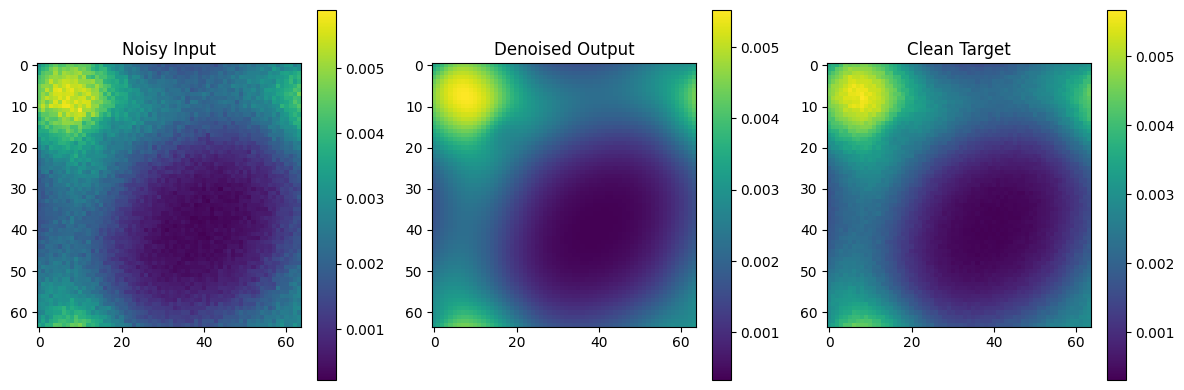

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import register_keras_serializable
import matplotlib.pyplot as plt

# === Custom Layer ===
@register_keras_serializable()
class Renormalize(layers.Layer):
    def __init__(self, target_sum=8.0, **kwargs):
        super().__init__(**kwargs)
        self.target_sum = target_sum

    def call(self, inputs):
        x_sum = tf.reduce_sum(inputs, axis=[1, 2, 3], keepdims=True)
        return inputs / (x_sum + 1e-8) * self.target_sum

    def get_config(self):
        config = super().get_config()
        config.update({'target_sum': self.target_sum})
        return config

# === Custom Loss ===
@register_keras_serializable()
def jensen_shannon_divergence_loss(y_true, y_pred):
    y_t = tf.cast(y_true, tf.float32)
    y_p = tf.cast(y_pred, tf.float32)

    y_t = tf.reshape(y_t, [tf.shape(y_t)[0], -1])
    y_p = tf.reshape(y_p, [tf.shape(y_p)[0], -1])

    y_t /= tf.reduce_sum(y_t, axis=1, keepdims=True) + 1e-8
    y_p /= tf.reduce_sum(y_p, axis=1, keepdims=True) + 1e-8

    m = 0.5 * (y_t + y_p)

    kl_true = tf.reduce_sum(y_t * tf.math.log((y_t + 1e-8) / (m + 1e-8)), axis=1)
    kl_pred = tf.reduce_sum(y_p * tf.math.log((y_p + 1e-8) / (m + 1e-8)), axis=1)

    jsd = 0.5 * (kl_true + kl_pred)

    return tf.reduce_mean(jsd)




# === Model Builder ===
def create_cae(input_shape, target_sum=8.0):
    input_layer = layers.Input(shape=input_shape)

    # Encoder with downsampling
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(input_layer)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Bottleneck
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)

    # Decoder with upsampling
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    #sigmoid to 0-1 scale then norm to nelec
    x = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)  # Changed to sigmoid

    # Normalize to target sum
    output_layer = Renormalize(target_sum=target_sum)(x)

    return models.Model(inputs=input_layer, outputs=output_layer)

# Learning rate schedule
lr_schedule = callbacks.LearningRateScheduler(
    lambda epoch: 1e-3 * (0.5 ** (epoch // 10)),  # Halve LR every 10 epochs
    verbose=1
)

# === Main Execution ===
if __name__ == '__main__':
    input_shape = (64, 64, 1)


    cae = create_cae(input_shape)

    cae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=jensen_shannon_divergence_loss)

    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = cae.fit(x_train, y_train,
                  validation_data=(x_val, y_val),
                  epochs=100,
                  batch_size=32,
                  callbacks=[early_stop, lr_schedule],
                  shuffle=True,
                  verbose=1)


    cae.save("CAE.keras")

    # Predict and plot
    i = 0
    denoised = cae.predict(x_test[i:i+1])[0, ..., 0]

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(x_test[i, ..., 0], cmap='viridis')
    plt.title("Noisy Input")
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.imshow(denoised, cmap='viridis')
    plt.title("Denoised Output")
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.imshow(y_test[i, ..., 0], cmap='viridis')
    plt.title("Clean Target")
    plt.colorbar()

    plt.tight_layout()
    plt.show()


In [21]:
cae.save("CAE.keras")

In [23]:


# must beat the model predicting the average
test_avg = np.mean(x_test[:,:,:,0],axis=0)
print("2 norm difference")
print("Mean vs DFT 2 norm diff")
print(np.linalg.norm(test_avg-minorized_ref_d))

print("prediction of one test sample vs DFT")
print(np.linalg.norm(cae.predict(x_test[0,:,:].reshape(1,64,64,1))[0,:,:,0]-minorized_ref_d))
print()

print("divergence difference")
mean_pred = cae.predict(np.mean(x_test.copy(),axis=0).reshape(1,64,64,1))                 
print("JSD (bar{x_test},y_dft):", jensen_shannon_divergence_loss(test_avg, minorized_ref_d.copy()))
print("JSD (CAE(bar{x}),y_dft):", jensen_shannon_divergence_loss(np.squeeze(mean_pred), minorized_ref_d.copy()))
print("JSD (CAE(_i}),y_dft):", jensen_shannon_divergence_loss(cae.predict(x_test[0,:,:].reshape(1,64,64,1))[0,:,:,0], minorized_ref_d.copy()))


2 norm difference
Mean vs DFT 2 norm diff
0.0003981657459381072
prediction of one test sample vs DFT
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
0.00012086543574725851

divergence difference
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
JSD (bar{x_test},y_dft): tf.Tensor(1.5349532e-06, shape=(), dtype=float32)
JSD (CAE(bar{x}),y_dft): tf.Tensor(1.6411455e-07, shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
JSD (CAE(_i}),y_dft): tf.Tensor(1.2225618e-07, shape=(), dtype=float32)


In [24]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import layers

# === Custom Layer ===
@tf.keras.utils.register_keras_serializable()
class Renormalize(layers.Layer):
    def __init__(self, target_sum=8.0, **kwargs):
        super().__init__(**kwargs)
        self.target_sum = target_sum

    def call(self, inputs):
        x_sum = tf.reduce_sum(inputs, axis=[1, 2, 3], keepdims=True)
        return inputs / (x_sum + 1e-8) * self.target_sum

    def get_config(self):
        config = super().get_config()
        config.update({'target_sum': self.target_sum})
        return config

# === Custom JSD Loss ===
@tf.keras.utils.register_keras_serializable()
def jensen_shannon_divergence_loss(y_true, y_pred):
    y_t = tf.cast(y_true, tf.float32)
    y_p = tf.cast(y_pred, tf.float32)

    y_t = tf.reshape(y_t, [tf.shape(y_t)[0], -1])
    y_p = tf.reshape(y_p, [tf.shape(y_p)[0], -1])

    y_t /= tf.reduce_sum(y_t, axis=1, keepdims=True) + 1e-8
    y_p /= tf.reduce_sum(y_p, axis=1, keepdims=True) + 1e-8

    m = 0.5 * (y_t + y_p)

    kl_true = tf.reduce_sum(y_t * tf.math.log((y_t + 1e-8) / (m + 1e-8)), axis=1)
    kl_pred = tf.reduce_sum(y_p * tf.math.log((y_p + 1e-8) / (m + 1e-8)), axis=1)

    jsd = 0.5 * (kl_true + kl_pred)

    return tf.reduce_mean(jsd)


In [25]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.0, max_pooling=True):
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = BatchNormalization()(conv, training=False)
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv)
    else:
        next_layer = conv
    skip_connection = conv
    return next_layer, skip_connection

def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    up = Conv2DTranspose(n_filters, (3, 3), strides=(2, 2), padding='same')(prev_layer_input)
    merge = concatenate([up, skip_layer_input], axis=3)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    return conv


In [26]:
def UNetDenoiser(input_shape=(64, 64, 1), n_filters=32, target_sum=8.0):
    inputs = Input(input_shape)

    # Encoder
    c1 = EncoderMiniBlock(inputs, n_filters, dropout_prob=0.0)
    c2 = EncoderMiniBlock(c1[0], n_filters*2)
    c3 = EncoderMiniBlock(c2[0], n_filters*4)
    c4 = EncoderMiniBlock(c3[0], n_filters*8, dropout_prob=0.3)
    c5 = EncoderMiniBlock(c4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)

    # Decoder
    u6 = DecoderMiniBlock(c5[0], c4[1], n_filters*8)
    u7 = DecoderMiniBlock(u6, c3[1], n_filters*4)
    u8 = DecoderMiniBlock(u7, c2[1], n_filters*2)
    u9 = DecoderMiniBlock(u8, c1[1], n_filters)

    # Output
    conv_final = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u9)
    output = Conv2D(1, 1, activation='sigmoid', padding='same')(conv_final)
    output = Renormalize(target_sum=target_sum)(output)

    return Model(inputs=inputs, outputs=output)


In [27]:
model = UNetDenoiser(input_shape=(64, 64, 1), n_filters=32, target_sum=8.0)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=jensen_shannon_divergence_loss)

history = model.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    epochs=100,
                    batch_size=32,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
                    shuffle=True,
                    verbose=1)

model.save("UNet_Denoiser.keras")


Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 95s 573ms/step - loss: 0.0045 - val_loss: 0.0440
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 87s 552ms/step - loss: 1.0088e-04 - val_loss: 0.0404
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 86s 548ms/step - loss: 8.7604e-05 - val_loss: 0.0290
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 86s 550ms/step - loss: 8.6101e-05 - val_loss: 0.0103
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 88s 557ms/step - loss: 8.2477e-05 - val_loss: 0.0010
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 90s 570ms/step - loss: 8.3828e-05 - val_loss: 7.7435e-05
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 89s 567ms/step - loss: 7.5582e-05 - val_loss: 7.5358e-05
Epoch 8/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 90s 575ms/step - loss: 7.4623e-05 - val_loss: 7.0401e-05
Epoch 9/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 89s 567ms/step - loss: 7.8975e-05 - val_loss: 1.2825e-04
Epoch 10/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 89s 567ms/step - loss: 7.5357e-05 - val_loss: 1.3734e-04
Epoch 11/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 9

In [30]:


# must beat the model predicting the average
test_avg = np.mean(x_test[:,:,:,0],axis=0)
print("2 norm difference")
print("Mean vs DFT 2 norm diff")
print(np.linalg.norm(test_avg-minorized_ref_d))

print("prediction of one test sample vs DFT")
print(np.linalg.norm(model.predict(x_test[0,:,:].reshape(1,64,64,1))[0,:,:,0]-minorized_ref_d))
print()

print("divergence difference")
mean_pred = model.predict(np.mean(x_test.copy(),axis=0).reshape(1,64,64,1))                 
print("JSD (bar{x_test},y_dft):", jensen_shannon_divergence_loss(test_avg, minorized_ref_d.copy()))
print("JSD (CAE(bar{x}),y_dft):", jensen_shannon_divergence_loss(np.squeeze(mean_pred), minorized_ref_d.copy()))
print("JSD (CAE(_i}),y_dft):", jensen_shannon_divergence_loss(model.predict(x_test[0,:,:].reshape(1,64,64,1))[0,:,:,0], minorized_ref_d.copy()))


2 norm difference
Mean vs DFT 2 norm diff
0.0003981657459381072
prediction of one test sample vs DFT
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
0.0006542566762872841

divergence difference
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
JSD (bar{x_test},y_dft): tf.Tensor(1.5349532e-06, shape=(), dtype=float32)
JSD (CAE(bar{x}),y_dft): tf.Tensor(3.127828e-06, shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
JSD (CAE(_i}),y_dft): tf.Tensor(3.2613261e-06, shape=(), dtype=float32)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


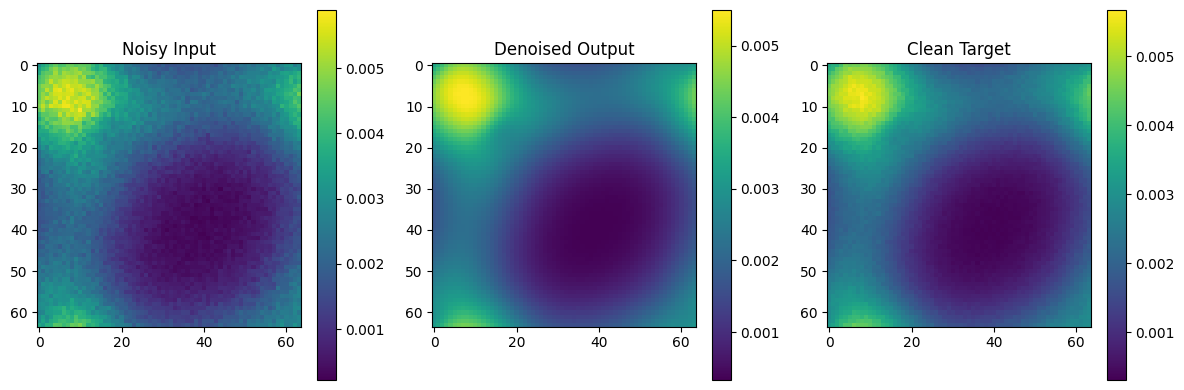

In [29]:
i = 0
denoised = model.predict(x_test[i:i+1])[0, ..., 0]

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(x_test[i, ..., 0], cmap='viridis')
plt.title("Noisy Input")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(denoised, cmap='viridis')
plt.title("Denoised Output")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(y_test[i, ..., 0], cmap='viridis')
plt.title("Clean Target")
plt.colorbar()

plt.tight_layout()
plt.show()


In [28]:
print("here")

here


In [42]:
a = .32
x_m = np.squeeze(np.mean(x_test.copy(),axis=0))
print(x_m.shape)
print(minorized_ref_d.shape)
print("mean:", jensen_shannon_divergence_loss(a*x_m+(1-a)*minorized_ref_d, minorized_ref_d.copy()))
#print("mean:", jensen_shannon_divergence_loss((1-a)*np.mean(x_test.copy(),axis=0)+a*y_dft[0].copy(), y_dft[0].copy()))
print(1/a**2)


(64, 64)
(64, 64)
mean: tf.Tensor(1.1130109e-07, shape=(), dtype=float32)
9.765625


In [41]:
#check the number of electrons
# need to ensure this is kept true throught taining
print("number of electron is should = 8",np.sum(denoised.sum(axis=1)))


number of electron is should = 8 8.0
